In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = "cs231n/assignments/assignment2/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_coco_dataset.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Image Captioning with RNNs
In this exercise, you will implement vanilla Recurrent Neural Networks and use them to train a model that can generate novel captions for images.

In [2]:

# Setup cell.
import time, os, json
import numpy as np
import torch
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers_pytorch import *
from cs231n.captioning_solver_pytorch import CaptioningSolverPytorch
from cs231n.classifiers.rnn_pytorch import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
For this exercise, we will use the 2014 release of the [COCO dataset](https://cocodataset.org/), a standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

**Image features.** We have preprocessed the data and extracted features for you already. For all images, we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet, and these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5`. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512 using Principal Component Analysis (PCA), and these features are stored in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`. The raw images take up nearly 20GB of space so we have not included them in the download. Since all images are taken from Flickr, we have stored the URLs of the training and validation images in the files `train2014_urls.txt` and `val2014_urls.txt`. This allows you to download images on-the-fly for visualization.

**Captions.** Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` from the file `cs231n/coco_utils.py` to convert NumPy arrays of integer IDs back into strings.

**Tokens.** There are a couple special tokens that we add to the vocabulary, and we have taken care of all implementation details around special tokens for you. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens.

You can load all of the COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `cs231n/coco_utils.py`. Run the following cell to do so:

In [4]:
# Load COCO data from disk into a dictionary.
# We'll work with dimensionality-reduced features for the remainder of this assignment,
# but you can also experiment with the original features on your own by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /Users/liujiaxi/Desktop/cs231n/assignment2/cs231n/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Inspect the Data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch` function from the file `cs231n/coco_utils.py` to sample minibatches of data from the data structure returned from `load_coco_data`. Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

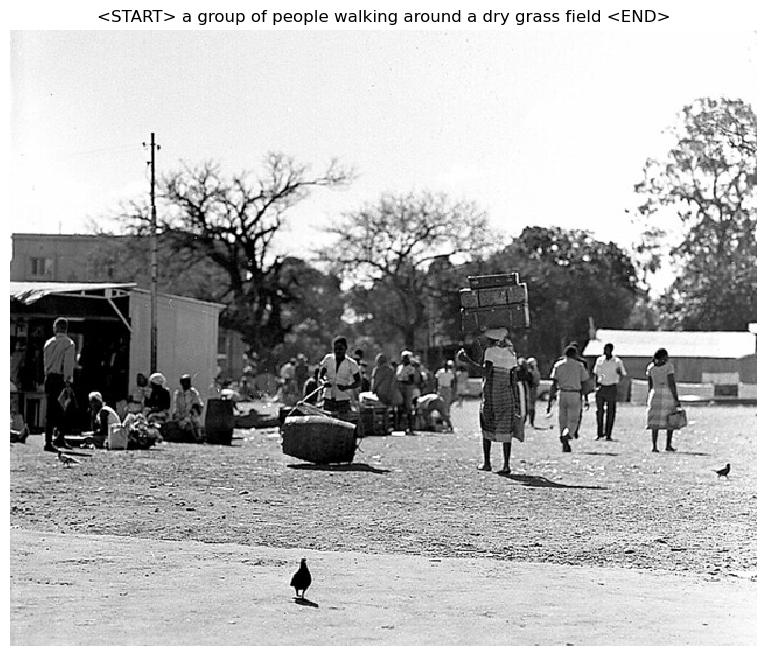

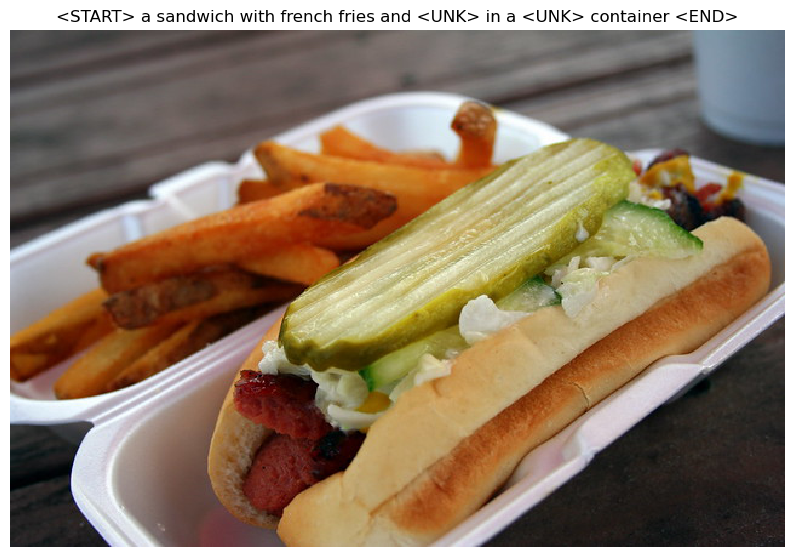

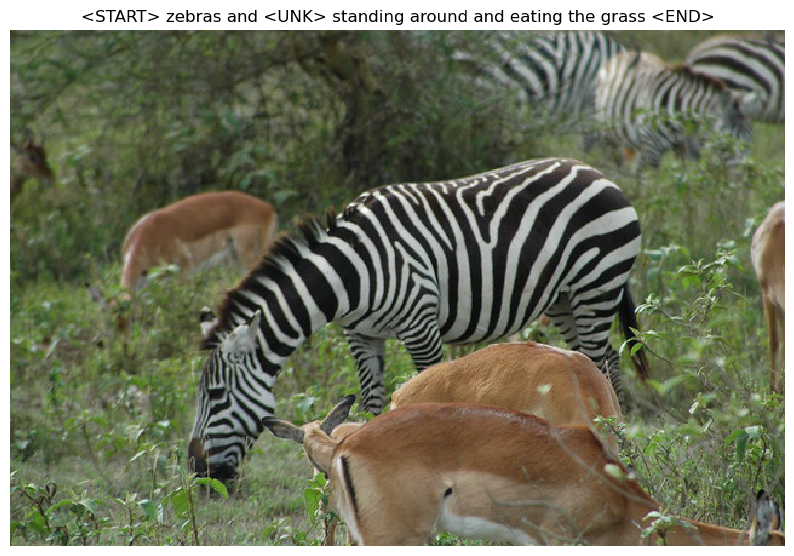

In [11]:
# Sample a minibatch and show the images and captions.
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Network
As discussed in lecture, we will use Recurrent Neural Network (RNN) language models for image captioning. The file `cs231n/rnn_layers_pytorch.py` contains implementations of different layer types that are needed for recurrent neural networks, and the file `cs231n/classifiers/rnn_pytorch.py` uses these layers to implement an image captioning model.

We will first implement different types of RNN layers in `cs231n/rnn_layers_pytorch.py`.

# Vanilla RNN: Step Forward
Open the file `cs231n/rnn_layers_pytorch.py`. This file implements the forward passes for different types of layers that are commonly used in recurrent neural networks. Note that since we use pytorch, the backward pass will be handled by pytorch's autograd.

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network. After doing so run the following to check your implementation. You should see errors on the order of e-8 or less.

In [15]:
N, D, H = 3, 10, 4

x = torch.from_numpy(np.linspace(-0.4, 0.7, num=N*D).reshape(N, D))
prev_h = torch.from_numpy(np.linspace(-0.2, 0.5, num=N*H).reshape(N, H))
Wx = torch.from_numpy(np.linspace(-0.1, 0.9, num=D*H).reshape(D, H))
Wh = torch.from_numpy(np.linspace(-0.3, 0.7, num=H*H).reshape(H, H))
b = torch.from_numpy(np.linspace(-0.2, 0.4, num=H))

next_h = rnn_step_forward(x, prev_h, Wx, Wh, b).numpy()
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: Step Backward
Since we implemented `rnn_step_forward` with pytorch, we do NOT have to implement `rnn_step_backward`. We can verify pytorch autograd backward
pass using our numerical gradient checker.

However, if you are feeling adventurous, you can try to implement `rnn_step_backward` yourself. It is not required in this assignment though.

In [18]:
from cs231n.rnn_layers_pytorch import rnn_step_forward

# Create test inputs
np.random.seed(231)
N, D, H = 4, 5, 6
x = torch.from_numpy(np.random.randn(N, D))
h = torch.from_numpy(np.random.randn(N, H))
Wx = torch.from_numpy(np.random.randn(D, H))
Wh = torch.from_numpy(np.random.randn(H, H))
b = torch.from_numpy(np.random.randn(H))

# Enable gradient tracking and do rnn forward pass
for tensor in [x, h, Wx, Wh, b]:
  tensor.requires_grad_()
next_h = rnn_step_forward(x, h, Wx, Wh, b)

# Simulate random upstream gradients and do a backward pass using pytorch's
# autograd.
dnext_h = torch.from_numpy(np.random.randn(*next_h.shape))
next_h.backward(dnext_h)

# Collect gradient in separate numpy arrays
dx = x.grad.detach().numpy()
dh = h.grad.detach().numpy()
dWx = Wx.grad.detach().numpy()
dWh = Wh.grad.detach().numpy()
db = b.grad.detach().numpy()
dnext_h = dnext_h.detach().numpy()

# Also convert test inputs to numpy arrays
x =  x.detach().numpy()
h =  h.detach().numpy()
Wx = Wx.detach().numpy()
Wh = Wh.detach().numpy()
b =  b.detach().numpy()

# Wrap our forward pass to support numpy array input and output. We use
# `torch.no_grad()` to explicitly disable gradient tracking.
def rnn_step_forward_numpy(x, h, Wx, Wh, b):
  with torch.no_grad():
    return rnn_step_forward(
        torch.from_numpy(x),
        torch.from_numpy(h),
        torch.from_numpy(Wx),
        torch.from_numpy(Wh),
        torch.from_numpy(b),
    ).numpy()

# Compute numerical gradients and compare.
fx = lambda x: rnn_step_forward_numpy(x, h, Wx, Wh, b)
fh = lambda h: rnn_step_forward_numpy(x, h, Wx, Wh, b)
fWx = lambda Wx: rnn_step_forward_numpy(x, h, Wx, Wh, b)
fWh = lambda Wh: rnn_step_forward_numpy(x, h, Wx, Wh, b)
fb = lambda b: rnn_step_forward_numpy(x, h, Wx, Wh, b)

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dh_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

# You should see errors on the order of 1e-9 or less
print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.2951754819754224e-10
dh error:  2.5835726537045397e-10
dWx error:  1.1411752934211496e-09
dWh error:  1.5923139233430823e-10
db error:  1.708752322503098e-11


# Vanilla RNN: Forward
Now that you have implemented the forward for a single timestep of a vanilla RNN, you will use it to implement a RNN that processes an entire sequence of data.

In the file `cs231n/rnn_layers_pytorch.py`, implement the function `rnn_forward`. This should be implemented using the `rnn_step_forward` function that you defined above. After doing so run the following to check your implementation. You should see errors on the order of `e-7` or less.

In [26]:
from cs231n.rnn_layers_pytorch import rnn_forward

N, T, D, H = 2, 3, 4, 5

x = torch.from_numpy(np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D))
h0 = torch.from_numpy(np.linspace(-0.3, 0.1, num=N*H).reshape(N, H))
Wx = torch.from_numpy(np.linspace(-0.2, 0.4, num=D*H).reshape(D, H))
Wh = torch.from_numpy(np.linspace(-0.4, 0.1, num=H*H).reshape(H, H))
b = torch.from_numpy(np.linspace(-0.7, 0.1, num=H))

h = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466180186066e-08


# Vanilla RNN: Backward
As before, we can verify pytorch autograd backward pass using our numerical gradient checker. You can also you can try to implement `rnn_step_backward` yourself if you want. It is not required in this assignment though.



In [28]:
from cs231n.rnn_layers_pytorch import rnn_forward

# Create test inputs
np.random.seed(231)
N, D, T, H = 2, 3, 10, 5
x = torch.from_numpy(np.random.randn(N, T, D))
h0 = torch.from_numpy(np.random.randn(N, H))
Wx = torch.from_numpy(np.random.randn(D, H))
Wh = torch.from_numpy(np.random.randn(H, H))
b = torch.from_numpy(np.random.randn(H))

# Enable gradient tracking and do forward pass
for tensor in [x, h0, Wx, Wh, b]:
  tensor.requires_grad_()
h = rnn_forward(x, h0, Wx, Wh, b)

# Simulate random upstream gradients and do a backward pass using pytorch's
# autograd.
dh = torch.from_numpy(np.random.randn(*h.shape))
h.backward(dh)

# Collect gradient in separate numpy arrays
dx = x.grad.detach().numpy()
dh0 = h0.grad.detach().numpy()
dWx = Wx.grad.detach().numpy()
dWh = Wh.grad.detach().numpy()
db = b.grad.detach().numpy()
dh = dh.detach().numpy()

# Also convert test inputs to numpy arrays
x =  x.detach().numpy()
h0 =  h0.detach().numpy()
Wx = Wx.detach().numpy()
Wh = Wh.detach().numpy()
b =  b.detach().numpy()

# Wrap our forward pass to support numpy array input and output. We use
# `torch.no_grad()` to explicitly disable gradient tracking.
def rnn_forward_numpy(x, h0, Wx, Wh, b):
  with torch.no_grad():
    return rnn_forward(
        torch.from_numpy(x),
        torch.from_numpy(h0),
        torch.from_numpy(Wx),
        torch.from_numpy(Wh),
        torch.from_numpy(b),
    ).numpy()


fx = lambda x: rnn_forward_numpy(x, h0, Wx, Wh, b)
fh0 = lambda h0: rnn_forward_numpy(x, h0, Wx, Wh, b)
fWx = lambda Wx: rnn_forward_numpy(x, h0, Wx, Wh, b)
fWh = lambda Wh: rnn_forward_numpy(x, h0, Wx, Wh, b)
fb = lambda b: rnn_forward_numpy(x, h0, Wx, Wh, b)

dx_num = eval_numerical_gradient_array(fx, x, dh)
dh0_num = eval_numerical_gradient_array(fh0, h0, dh)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dh)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dh)
db_num = eval_numerical_gradient_array(fb, b, dh)

# You should see errors on the order of 1e-6 or less
print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.537376401938797e-09
dh0 error:  3.378112315807344e-09
dWx error:  7.232185116377654e-09
dWh error:  1.3157127320449188e-07
db error:  2.3609030091203296e-10


# Word Embedding: Forward
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

In the file `cs231n/rnn_layers_pytorch.py`, implement the function `word_embedding_forward` to convert words (represented by integers) into vectors. Run the following to check your implementation. You should see an error on the order of `e-8` or less.

In [29]:
N, T, V, D = 2, 4, 5, 3

x = torch.from_numpy(np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]]))
W = torch.from_numpy(np.linspace(0, 1, num=V*D).reshape(V, D))

out = word_embedding_forward(x, W).numpy()
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


# Word Embedding: Backward
As before, we can verify pytorch autograd backward pass using our numerical gradient checker. You can also you can try to implement `word_embedding_backward` yourself if you want. It is not required in this assignment though.

In [30]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = torch.from_numpy(np.random.randint(V, size=(N, T)))
W = torch.from_numpy(np.random.randn(V, D))
W.requires_grad_()

out = word_embedding_forward(x, W)
dout = torch.from_numpy(np.random.randn(*out.shape))
out.backward(dout)

dW = W.grad.detach().numpy()
x = x.detach().numpy()
W = W.detach().numpy()
dout = dout.detach().numpy()

def word_embedding_forward_numpy(x, W):
  return word_embedding_forward(
      torch.from_numpy(x),
      torch.from_numpy(W),
  ).numpy()

f = lambda W: word_embedding_forward_numpy(x, W)
dW_num = eval_numerical_gradient_array(f, W, dout)

# You should see an error on the order of 1e-11 or less
print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2774595693100364e-12


# Temporal Affine Layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. Because this is very similar to the affine layer that you implemented in assignment 2, we have provided this function for you in the `temporal_affine_forward`. Run the following to perform numeric gradient checking on the implementation. You should see errors on the order of `e-9` or less.

In [31]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = torch.from_numpy(np.random.randn(N, T, D))
w = torch.from_numpy(np.random.randn(D, M))
b = torch.from_numpy(np.random.randn(M))

for tensor in [x, w, b]:
  tensor.requires_grad_()
out = temporal_affine_forward(x, w, b)
dout = torch.from_numpy(np.random.randn(*out.shape))
out.backward(dout)

dx = x.grad.detach().numpy()
dw = w.grad.detach().numpy()
db = b.grad.detach().numpy()

x = x.detach().numpy()
w = w.detach().numpy()
b = b.detach().numpy()
dout = dout.detach().numpy()

def temporal_affine_forward_numpy(x, w, b):
  return temporal_affine_forward(
      torch.from_numpy(x),
      torch.from_numpy(w),
      torch.from_numpy(b),
  ).numpy()

fx = lambda x: temporal_affine_forward_numpy(x, w, b)
fw = lambda w: temporal_affine_forward_numpy(x, w, b)
fb = lambda b: temporal_affine_forward_numpy(x, w, b)

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  6.964219437046371e-10
dw error:  1.5772169135951167e-10
db error:  4.200725290973326e-11


# Temporal Softmax Loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `mask` array that tells it which elements of the scores count towards the loss.

Since this is very similar to the softmax loss function you implemented in assignment 1, we have implemented this loss function for you; look at the `temporal_softmax_loss` function in the file `cs231n/rnn_layers_pytorch.py`.

Run the following cell to sanity check the loss and perform numeric gradient checking on the function. You should see an error for dx on the order of `e-7` or less.

In [32]:
# Sanity check for temporal softmax loss
from cs231n.rnn_layers_pytorch import temporal_softmax_loss

N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * torch.from_numpy(np.random.randn(N, T, V))
    y = torch.from_numpy(np.random.randint(V, size=(N, T)))
    mask = torch.from_numpy(np.random.rand(N, T)) <= p
    print(temporal_softmax_loss(x, y, mask).item())

check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be within 2.2-2.4

# Gradient check for temporal softmax loss
np.random.seed(231231)
N, T, V = 7, 8, 9

x = torch.from_numpy(np.random.randn(N, T, V))
y = torch.from_numpy(np.random.randint(V, size=(N, T)))
mask = torch.from_numpy(np.random.rand(N, T) > 0.5)

x.requires_grad_()
loss = temporal_softmax_loss(x, y, mask, verbose=False)
loss.backward()
dx = x.grad.detach().numpy()
x = x.detach().numpy()
dx_num = eval_numerical_gradient(
    lambda x: temporal_softmax_loss(torch.from_numpy(x), y, mask), x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3027781774290146
23.02598595312723
2.2643611790293394
dx error:  5.5228696963589426e-08


# RNN for Image Captioning
Now that you have implemented the necessary layers, you can combine them to build an image captioning model. Open the file `cs231n/classifiers/rnn_pytorch.py` and look at the `CaptioningRNN` class.

Implement the forward pass of the model in the `loss` function. For now you only need to implement the case where `cell_type='rnn'` for vanilla RNNs; you will implement the LSTM case later. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-10` or less.

In [39]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    hidden_dim=H,
    cell_type='rnn',
    dtype=torch.float64
)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = torch.from_numpy(
        np.linspace(-1.4, 1.3, num=v.numel()).reshape(*v.shape))

features = torch.from_numpy(np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D))
captions = torch.from_numpy((np.arange(N * T) % V).reshape(N, T))

loss = model.loss(features, captions).item()
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.832355910027388
expected loss:  9.83235591003
difference:  2.611244553918368e-12


Run the following cell to perform numeric gradient checking on the `CaptioningRNN` class; you should see errors around the order of `e-6` or less.

In [40]:
np.random.seed(231)
torch.manual_seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = torch.from_numpy(np.random.randint(vocab_size, size=(batch_size, timesteps)))
features = torch.from_numpy(np.random.randn(batch_size, input_dim))

model = CaptioningRNN(
    word_to_idx,
    input_dim=input_dim,
    wordvec_dim=wordvec_dim,
    hidden_dim=hidden_dim,
    cell_type='rnn',
    dtype=torch.float64,
)

for k, v in model.params.items():
  v.requires_grad_()
loss = model.loss(features, captions)
loss.backward()
grads = {k: v.grad.detach().numpy() for k, v in model.params.items()}
for k, v in model.params.items():
  v.requires_grad_(False)

for param_name in sorted(grads.keys()):
    def fn(val):
      model.params[param_name] = torch.from_numpy(val)
      ret = model.loss(features, captions).numpy()
      return ret

    param_grad_num = eval_numerical_gradient(
        fn, model.params[param_name].numpy(), verbose=False, h=1e-6)

    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 1.360453e-09
W_proj relative error: 4.536653e-08
W_vocab relative error: 9.455365e-09
Wh relative error: 6.974167e-09
Wx relative error: 1.092991e-06
b relative error: 4.801023e-09
b_proj relative error: 9.369031e-09
b_vocab relative error: 4.671456e-09


# Overfit RNN Captioning Model on Small Data
Similar to the `Solver` class that we used to train image classification models on the previous assignment, on this assignment we use a `CaptioningSolverPytorch` class to train image captioning models. Open the file `cs231n/captioning_solver_pytorch.py` and read through the `CaptioningSolverPytorch` class; it should look very familiar.

Once you have familiarized yourself with the API, run the following to make sure your model overfits a small sample of 100 training examples. You should see a final loss of less than 0.1.

base dir  /Users/liujiaxi/Desktop/cs231n/assignment2/cs231n/datasets/coco_captioning
(Iteration 1 / 100) loss: 80.027161
(Iteration 11 / 100) loss: 25.580212
(Iteration 21 / 100) loss: 3.889988
(Iteration 31 / 100) loss: 0.640994
(Iteration 41 / 100) loss: 0.133345
(Iteration 51 / 100) loss: 0.057642
(Iteration 61 / 100) loss: 0.028619
(Iteration 71 / 100) loss: 0.022346
(Iteration 81 / 100) loss: 0.018517
(Iteration 91 / 100) loss: 0.016731


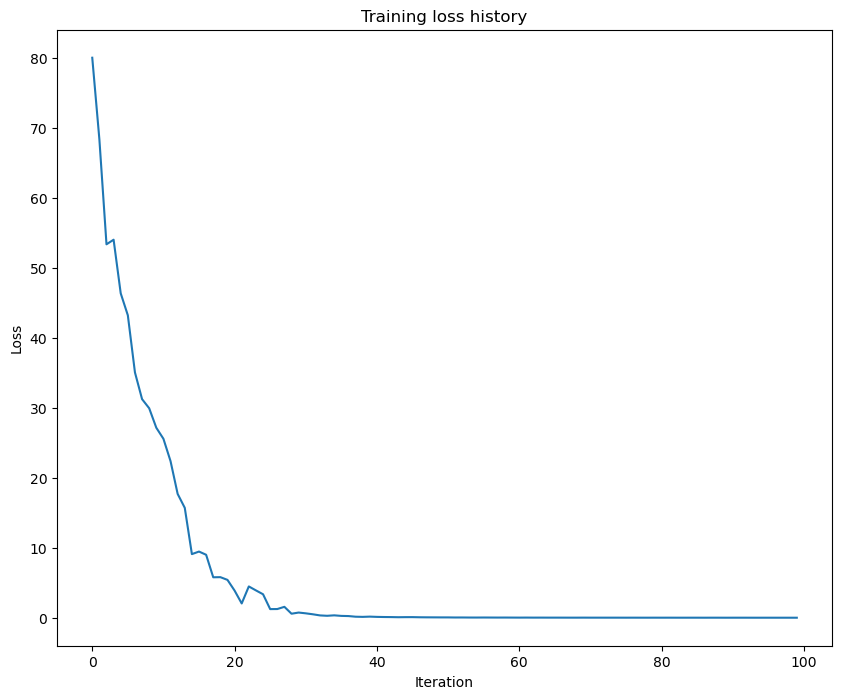

In [41]:
np.random.seed(231)
torch.manual_seed(231)

small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
    cell_type='rnn',
    word_to_idx=data['word_to_idx'],
    input_dim=data['train_features'].shape[1],
    hidden_dim=512,
    wordvec_dim=256,
)

small_rnn_solver = CaptioningSolverPytorch(
    small_rnn_model, small_data,
    num_epochs=50,
    batch_size=25,
    learning_rate=5e-3,
    verbose=True, print_every=10,
)

small_rnn_solver.train()

# Plot the training losses.
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.1.

In [42]:
print('Final loss: ', small_rnn_solver.loss_history[-1])

Final loss:  0.013368929


# RNN Sampling at Test Time
Unlike classification models, image captioning models behave very differently at training time vs. at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep and feed the sample as input to the RNN at the next timestep.

In the file `cs231n/classifiers/rnn_pytorch.py`, implement the `sample` method for test-time sampling. After doing so, run the following to sample from your overfitted model on both training and validation data. The samples on training data should be very good. The samples on validation data, however, probably won't make sense.

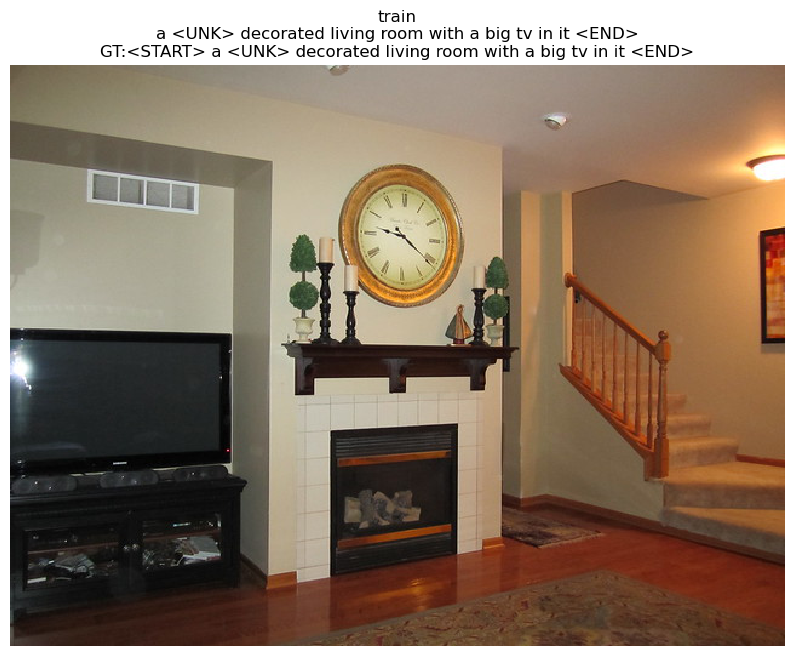

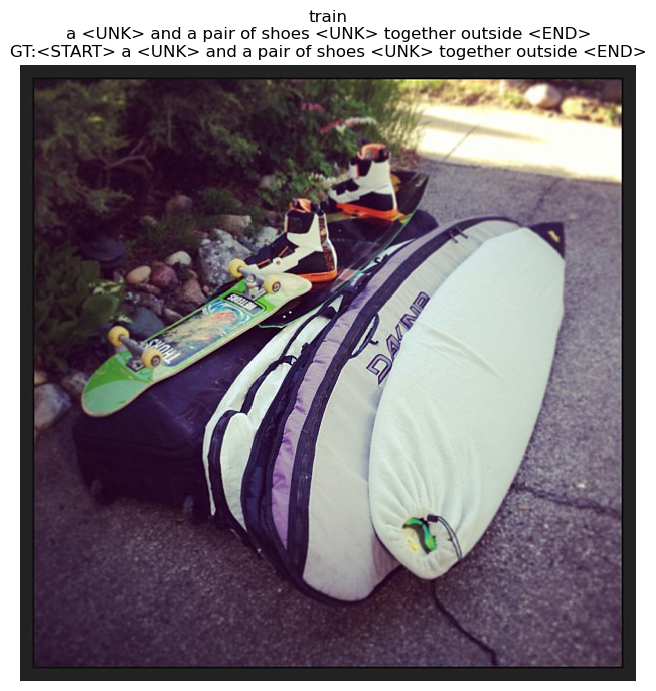

RemoteDisconnected: Remote end closed connection without response

In [46]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(torch.from_numpy(features)).numpy()
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: 
            print(f"跳过无法下载的图片: {url}")
            continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# Inline Question 1

In our current image captioning setup, our RNN language model produces a word at every timestep as its output. However, an alternate way to pose the problem is to train the network to operate over _characters_ (e.g. 'a', 'b', etc.) as opposed to words, so that at it every timestep, it receives the previous character as input and tries to predict the next character in the sequence. For example, the network might generate a caption like

'A', ' ', 'c', 'a', 't', ' ', 'o', 'n', ' ', 'a', ' ', 'b', 'e', 'd'

Can you describe one advantage of an image-captioning model that uses a character-level RNN? Can you also describe one disadvantage? HINT: there are several valid answers, but it might be useful to compare the parameter space of word-level and character-level models.

**Your Answer:**
Advantage: A character-level RNN has a tiny vocabulary (∣V_char∣ ≪ ∣V_word∣), so its embedding/output layers have far fewer parameters. It’s open-vocabulary: it can spell unseen words (names, rare objects, new terms) instead of emitting <UNK>.

Disadvantage: Sequences become ~5–10× longer than word sequences, so training/inference are slower and optimization is harder (longer credit assignment, more vanishing/exploding risk). It often needs larger/stronger models to capture word-level semantics and can produce misspellings or incoherent long-range structure.
